# MC dropout abstention (baseline mode)

Produce N forward passes and record variance and mean.

Train model that receives variance and mean of a particular diagnostic on a particular visit and models if that prediction is True positive or False positive.

baseline mode means:
1. I'm using validation set to train the LR on tp vs. fp. and test set to evaluate the model on an unseen data
2. I'm using a simple threshold of 0.5 on the logistic regressions.

In [1]:
from torch import nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

In [2]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(os.path.dirname(cwd)).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(os.path.dirname(cwd)) # parent directory
os.chdir(new_cwd)

In [3]:
import sys
import os
this_dir = ".."
if this_dir not in sys.path:
    sys.path.append(this_dir)

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model, outs2df_mc, compute_metrics

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import ParameterGrid, ParameterSampler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
idx = pd.IndexSlice

from config import Settings; settings = Settings()

import wandb

In [4]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
dataset_id = 'diag_only'
grouping = 'ccs'
batch_size=64

In [6]:
dataset_folder = os.path.join(settings.data_base,settings.model_ready_dataset_folder,dataset_id)
print('dataset at',dataset_folder)

dataset = DiagnosesDataset(os.path.join(dataset_folder,'dataset.json'),grouping)

train_dataset = DiagnosesDataset(os.path.join(dataset_folder,'train_subset.json'),grouping)
val_dataset = DiagnosesDataset(os.path.join(dataset_folder,'val_subset.json'),grouping)
test_dataset = DiagnosesDataset(os.path.join(dataset_folder,'test_subset.json'),grouping)


len(train_dataset)
len(val_dataset)
len(test_dataset)


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset),shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset)) #batch_size here is arbitrary and doesn't affect total validation speed
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset))

dataset at data/model_ready_dataset/diag_only


5249

1125

1125

In [7]:
input_size = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]
hidden_size = 100
num_layers = 1
n_labels = input_size
model_type = 'gru'

In [8]:
dropout = 0.2
dropouti = dropout
dropoutw = dropout
dropouto = dropout

In [9]:
model = VariationalRNN(input_size=input_size,
                       hidden_size=hidden_size,
                       n_labels=n_labels,
                       num_layers=num_layers,
                       rnn_type=model_type,
                       dropouti=dropouti,
                       dropoutw=dropoutw,
                       dropouto=dropouto
                      )

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
epochs = 10

In [11]:
losses = []
for epoch in range(epochs):
    eval_model(model,val_dataloader,dataset,['recall@30'])[1]['recall@30_adm']
    loss = train_one_epoch(model,train_dataloader,epoch,criterion,opt)
    losses.append(loss)
    print(f'epoch: {epoch+1} | loss: {loss}')

0.09338595837009094

epoch: 1 | loss: 0.1768575266721737


0.5978395954393771

epoch: 2 | loss: 0.12670961363487934


0.6468799973735518

epoch: 3 | loss: 0.12123737924070244


0.6683152002844288

epoch: 4 | loss: 0.11769239712192352


0.6644883834566765

epoch: 5 | loss: 0.114641822695014


0.6796602510058005

epoch: 6 | loss: 0.1127079840166023


0.692805877349853

epoch: 7 | loss: 0.11075322985290045


0.7030957856054423

epoch: 8 | loss: 0.10890622885830431


0.7053674280792359

epoch: 9 | loss: 0.10731690341090581


0.6965423997021247

epoch: 10 | loss: 0.10692487639116954


In [12]:
res,golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)
res.head(3)

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index n_pass                                                     
21     1         1       0.002370  0.365775  0.118136  0.084879  0.000311   
                 2       0.037214  0.644784  0.171708  0.203601  0.002078   
                 3       0.001576  0.270992  0.328639  0.166716  0.000260   

                           diag_5    diag_6    diag_7    diag_8    diag_9  \
pat_id adm_index n_pass                                                     
21     1         1       0.014815  0.026685  0.020227  0.000684  0.006515   
                 2       0.061116  0.003191  0.003054  0.000455  0.006399   
                 3       0.024668  0.022760  0.037892  0.001908  0.059071   

                         ...  diag_262  diag_263  diag_264  diag_265  \
pat_id adm_index n_pass  ...                                           
21     1         1       ...  0.000388  0.003560  0.000047  0.001348   
                 2       ...  0.000239  0.003485  0.000034  0.004199   
                 3       ...  0.001974  0.026939  0.001050  0.004389   

                         diag_266  diag_267  diag_268  diag_269  diag_270  \
pat_id adm_index n_pass                                                     
21     1         1       0.181123  0.080933  0.001055  0.000202  0.006022   
                 2       0.158753  0.129864  0.000552  0.001395  0.000903   
                 3       0.280248  0.079964  0.004700  0.004929  0.018459   

                         diag_271  
pat_id adm_index n_pass            
21     1         1       0.033595  
                 2       0.037307  
                 3       0.143074  

[3 rows x 272 columns]

In [13]:
stats_res = res.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_res.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
21     1          0.040054  0.002548  0.280658  0.023643  0.136315  0.006583   
23     1          0.002655  0.000003  0.098212  0.001071  0.076780  0.000720   
61     1          0.007106  0.000069  0.192041  0.013838  0.066138  0.001082   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
21     1          0.161489  0.011599  0.009761  0.000218  ...  0.110771   
23     1          0.045078  0.000294  0.003900  0.000089  ...  0.064198   
61     1          0.148991  0.010004  0.048674  0.011126  ...  0.127110   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
21     1          0.005938  0.007281  0.000352  0.004915  8.759923e-05   
23     1          0.001240  0.003211  0.000012  0.000348  1.321151e-07   
61     1          0.007235  0.014189  0.000528  0.001849  2.089812e-06   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
21     1          0.005280  0.000032  0.055377  0.002862  
23     1          0.009467  0.000031  0.030938  0.000460  
61     1          0.009766  0.000101  0.029045  0.000505  

[3 rows x 544 columns]

In [14]:
k = 30
topk_outputs = stats_res.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_res.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_res.index)
topk_predictions.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
61,1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [15]:
TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

variances = stats_res.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
variances.head(3)

means = stats_res.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
means.head(3)

tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.002548,0.023643,0.006583,0.011599,0.000218,0.029802,0.000149,0.000145,1.072720e-05,0.004753,...,6.096235e-07,0.000499,3.454974e-07,0.000197,0.011514,0.005938,0.000352,8.759923e-05,0.000032,0.002862
23,1,0.000003,0.001071,0.000720,0.000294,0.000089,0.000021,0.000069,0.000005,6.843590e-07,0.000325,...,7.977818e-08,0.000003,8.776658e-08,0.000003,0.009773,0.001240,0.000012,1.321151e-07,0.000031,0.000460
61,1,0.000069,0.013838,0.001082,0.010004,0.011126,0.001952,0.006691,0.000142,1.449645e-06,0.000986,...,2.268845e-07,0.000006,2.183913e-06,0.000004,0.005429,0.007235,0.000528,2.089812e-06,0.000101,0.000505


,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.040054,0.280658,0.136315,0.161489,0.009761,0.097131,0.011942,0.008754,0.002009,0.063793,...,0.000693,0.013418,0.000336,0.011065,0.169927,0.110771,0.007281,0.004915,0.005280,0.055377
23,1,0.002655,0.098212,0.076780,0.045078,0.003900,0.004260,0.016483,0.001854,0.001371,0.026371,...,0.000391,0.001973,0.000366,0.001786,0.159781,0.064198,0.003211,0.000348,0.009467,0.030938
61,1,0.007106,0.192041,0.066138,0.148991,0.048674,0.033647,0.081883,0.013422,0.001437,0.050043,...,0.000657,0.003754,0.000756,0.002424,0.139360,0.127110,0.014189,0.001849,0.009766,0.029045


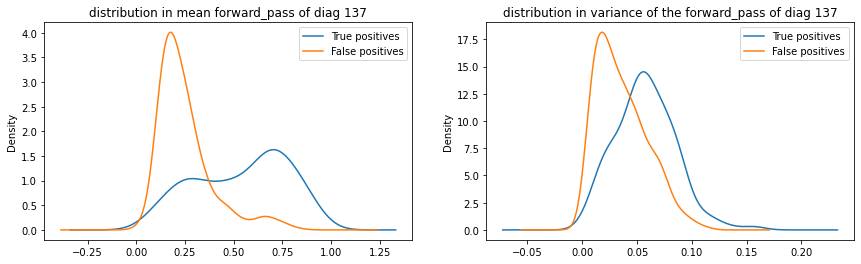

In [16]:
#parameter
diag = 137


diag_col = f'diag_{diag}'
plt.subplot(1,2,1)
tp_means[diag_col].plot.kde(label='True positives');
fp_means[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in mean forward_pass of diag {diag}');
plt.legend();
#plt.show();
plt.subplots_adjust(right=2) 
plt.subplot(1,2,2)
tp_variances[diag_col].plot.kde(label='True positives');
fp_variances[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in variance of the forward_pass of diag {diag}');
plt.legend();

# Model whether a prediction will be FP or TP

# Dumb classifier

since some diagnostics won't have enough data to train a model on, we will use 'dumb' classifiers to keep the pipeline consistent. These classifiers will always predict the positive class

In [76]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class DumbClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass
    def fit(self, X, y):
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        #self.classes_ = unique_labels(y)
        #self.X_ = X
        #self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
         # Check if fit has been called
        #check_is_fitted(self)
        
        # Input validation
        #X = check_array(X)
        y = np.zeros(shape=(X.shape[0],),dtype=int)
        return y
    
    def predict_proba(self,X):
        return np.array([[1,0]])
# test this out
from sklearn.pipeline import make_pipeline

X = np.ones(shape=(5,5))
y = np.random.randint(0,2,size=(5,))

pipe = make_pipeline(DumbClassifier())

pipe.fit(X,y)
pipe.predict(X) # Expecting all ones

Pipeline(steps=[('dumbclassifier', DumbClassifier())])

array([0, 0, 0, 0, 0])

# Build dataset

we shall build the dataset using the validation set (from the original train-val-test split).

We need:
1. obtain predictions on the validation set
2. gather all TP and FP examples
3. construct N tabular datasets (one for each diagnostic)
4. split each into train-test
5. train and test classifier
    1. metric should be precision, recall and f1

In [77]:
lr = LogisticRegression()

In [54]:
lr.fit([[1,1],[0,0]],[1,0])

LogisticRegression()

In [59]:
lr.predict_proba([[0.5,0.5]]).shape

(1, 2)

In [78]:
outs, golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)

In [79]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])

k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)
#topk_predictions.head(1)

TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

variances = stats_outs.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(1)

means = stats_outs.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
means.head(1)

tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.020552,0.278292,0.152279,0.135513,0.004699,0.056218,0.006255,0.003641,0.001793,0.042197,...,0.000667,0.010117,0.000234,0.019367,0.120169,0.08268,0.00595,0.003846,0.005637,0.044326


In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.linear_model import LogisticRegression

In [81]:
# need two conditions to decide wether to use the dumb classifier or not
# 1) threhsold on the number of examples
# 2) and there must be examples of both classes

df_metrics = pd.DataFrame(columns=['diag','precision','recall','f1','clf','type'])

clf_party = {}
threshold = 20
for diag in outs.columns:
    
    n_TP = (TP[diag] == True).sum()
    n_FP = (FP[diag] == True).sum()
    
    total_n = n_TP + n_FP
    
    if total_n < threshold or n_TP < 5 or n_FP < 5:
        #use dumb classifier
        clf = DumbClassifier()
        df_metrics = df_metrics.append({'diag':diag,'precision':np.nan,'recall':np.nan,'f1':np.nan,'clf':clf,'type':'dumb'},ignore_index=True)
    else:
        #use logistic regression
        
        ## create dataset
        mean_tp = means[diag][TP[diag]].to_frame('mean')
        mean_fp = means[diag][FP[diag]].to_frame('mean')
        
        var_tp = variances[diag][TP[diag]].to_frame('var')
        var_fp = variances[diag][FP[diag]].to_frame('var')
        
        df_tp = pd.concat([mean_tp,var_tp],axis=1).assign(label=0).reset_index(drop=True)
        df_fp = pd.concat([mean_fp,var_fp],axis=1).assign(label=1).reset_index(drop=True)
        
        df = pd.concat([df_tp,df_fp],ignore_index=True).sample(frac=1.0)
        
        ## split into train-test
        
        X_train,X_test,y_train,y_test = train_test_split(df[['mean','var']],df['label'],stratify=df['label'])
        
        ## train
        clf = LogisticRegression(class_weight="balanced");
        clf.fit(X_train,y_train);
        
        ## evaluate
        preds = clf.predict(X_test);
        
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        f1 = f1_score(y_test,preds)
        
        df_metrics = df_metrics.append({'diag':diag,'precision':precision,'recall':recall,'f1':f1,'clf':clf,'type':'model'},ignore_index=True)
    
    clf_party[diag] = clf
    

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

In [82]:
df_metrics.f1.describe()

count    128.000000
mean       0.790077
std        0.100953
min        0.333333
25%        0.739224
50%        0.797866
75%        0.860406
max        1.000000
Name: f1, dtype: float64

In [83]:
df_metrics = df_metrics.set_index('diag')
df_metrics.head(2)

,precision,recall,f1,clf,type
diag,,,,,
diag_0,NaN,NaN,NaN,DumbClassifier(),dumb
diag_1,0.818653,0.681034,0.743529,LogisticRegression(class_weight='balanced'),model


## Classifiers are trained. Now we need to apply them

In [84]:
# notice we use the test set now
outs, golden = outs2df_mc(model,test_dataloader,dataset,return_golden=True)

In [85]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_outs.head(3)

diag_0                  diag_1              diag_2  \
                      mean           var      mean       var      mean   
pat_id adm_index                                                         
111    1          0.003389  6.781458e-06  0.110533  0.003121  0.053718   
145    1          0.001227  2.728726e-07  0.467633  0.013534  0.195984   
199    1          0.026290  3.234065e-03  0.118492  0.002686  0.056296   

                              diag_3              diag_4                ...  \
                       var      mean       var      mean           var  ...   
pat_id adm_index                                                        ...   
111    1          0.000363  0.071027  0.001179  0.002383  1.136420e-05  ...   
145    1          0.008218  0.090025  0.001018  0.000727  6.442172e-07  ...   
199    1          0.000343  0.062752  0.003218  0.011570  2.920511e-04  ...   

                  diag_267            diag_268            diag_269  \
                      mean       var      mean       var      mean   
pat_id adm_index                                                     
111    1          0.067196  0.000786  0.007518  0.000054  0.001057   
145    1          0.084007  0.002001  0.012831  0.000179  0.001081   
199    1          0.091543  0.005362  0.004337  0.000010  0.001668   

                                diag_270            diag_271            
                           var      mean       var      mean       var  
pat_id adm_index                                                        
111    1          1.906835e-06  0.010742  0.000154  0.030980  0.000265  
145    1          9.268893e-07  0.017722  0.000371  0.039875  0.000709  
199    1          3.159698e-06  0.006834  0.000034  0.019984  0.000105  

[3 rows x 544 columns]

In [86]:
k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)

In [89]:
def abstain(row,df_metrics,stats_outs,threshold=None):
    """
    Receives a row which contains the predictions of all diagnoses (0 or 1) for a given admission.
    Also receives df_metrics, which contains the LRs trained on each diagnostic (that predicts if TP or FP)
    And stats_outs contains the means and variances of the forward passes.
    
    this function will turn some predictions from 1 to 0 if the LR model predicts it will be a FP.
    """
    new_row = row.copy()
    admission_forward_stats = stats_outs.loc[row.name,:]
    for index,elem in row.iteritems():
        if elem == 1:
            datapoint = admission_forward_stats[index].to_numpy()
            clf = df_metrics.loc[index,'clf']
            
            # proba of positive class pred
            pred = clf.predict_proba(datapoint.reshape((-1,2)))[0][1]
            
            if pred > threshold: #abstain
                new_row[index] = 0
    return new_row

and abstain from topk now

In [91]:
all_metrics_w_abstention

,threshsold 0.3,threshsold 0.4
metrics,,
precision@30_diag,0.423348,0.424000
recall@30_diag,0.104043,0.152699
f1@30_diag,0.124310,0.182809
precision@30_adm,0.631489,0.577159
recall@30_adm,0.204662,0.312925
f1@30_adm,0.288136,0.379660


In [92]:
# metrics of topk
metrics_normal = compute_metrics(topk_outputs_all_cols.fillna(0),topk_predictions,golden,['precision@30','recall@30','f1@30'])

# metrics of topk and abstention afterwards

all_metrics_w_abstention = None
for ix,th in enumerate(np.linspace(0.3,0.9,7)):

    top_k_predictions_abstained = topk_predictions.apply(lambda row: abstain(row,df_metrics,stats_outs,th),axis=1)
    topk_outputs_all_cols_after_abstention = topk_outputs_all_cols.fillna(0).mask(top_k_predictions_abstained == 0,0)
    metrics_w_abstention = compute_metrics(topk_outputs_all_cols_after_abstention,top_k_predictions_abstained,golden,['precision@30','recall@30','f1@30'])
    metrics_w_abstention.name = f'threshsold {th}'
    
    all_metrics_w_abstention = metrics_w_abstention if all_metrics_w_abstention is None else pd.concat([all_metrics_w_abstention,metrics_w_abstention],axis=1)
    print (f'Done {(ix+1)}')
print('Done ALL')

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done ALL


In [93]:
metrics_normal.name = 'initial top 30 retrieval'
pd.concat([metrics_normal,all_metrics_w_abstention],axis=1).iloc[3:]

,initial top 30 retrieval,threshsold 0.3,threshsold 0.4,threshsold 0.5,threshsold 0.6000000000000001,threshsold 0.7000000000000001,threshsold 0.8,threshsold 0.9
metrics,,,,,,,,
precision@30_adm,0.274991,0.631489,0.577159,0.461108,0.332377,0.294947,0.278753,0.275002
recall@30_adm,0.699241,0.204662,0.312925,0.463577,0.598133,0.665533,0.693980,0.699241
f1@30_adm,0.378322,0.288136,0.379660,0.434640,0.410954,0.393249,0.381803,0.378339


In [94]:
df_metrics

,precision,recall,f1,clf,type
diag,,,,,
diag_0,NaN,NaN,NaN,DumbClassifier(),dumb
diag_1,0.818653,0.681034,0.743529,LogisticRegression(class_weight='balanced'),model
diag_2,0.740000,0.627119,0.678899,LogisticRegression(class_weight='balanced'),model
diag_3,0.950000,0.584615,0.723810,LogisticRegression(class_weight='balanced'),model
diag_4,1.000000,1.000000,1.000000,LogisticRegression(class_weight='balanced'),model
...,...,...,...,...,...
diag_267,0.937500,0.714286,0.810811,LogisticRegression(class_weight='balanced'),model
diag_268,0.833333,0.500000,0.625000,LogisticRegression(class_weight='balanced'),model
diag_269,NaN,NaN,NaN,DumbClassifier(),dumb


In [100]:
df_metrics.iloc[1]['clf'].predict_proba(np.array([[1,1]]))

array([[0.96902442, 0.03097558]])

-----